# 量子分类器 （Quantum Classifier）


<em> Copyright (c) 2020 Institute for Quantum Computing, Baidu Inc. All Rights Reserved. </em>

## 概览

在本教程中我们一起来学习下如何利用量子神经网络来完成**两分类**任务（后续我们会补充难度更大的多分类任务）。这类方法早期工作的主要代表是 Mitarai et al.(2018) 的 [Quantum Circuit Learning](https://arxiv.org/abs/1803.00745) [1] 还有 Schuld et al.(2018) 的 [Circuit-centric quantum classifiers](https://arxiv.org/abs/1804.00633) [2]。本教程重点复现了前者的理论工作, 请读者跟随我们一起探索其中的奥秘。有经典机器学习基础的读者不妨参考下图思考一下，这个框架和经典的方法有什么异同。

<img src="figures/pipeline.png" width="900" >



首先我们还是引入需要的 library和 package：

In [1]:
import time
import matplotlib
import numpy as np
from numpy import pi as PI
from matplotlib import pyplot as plt

from paddle import fluid
from paddle.fluid.framework import ComplexVariable
from paddle.complex import matmul, transpose
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix

In [2]:
# 这是教程中会用到的几个主要函数，下面我们来逐一分析
__all__ = [
    "circle_data_point_generator",
    "data_point_plot",
    "heatmap_plot",
    "myRy",
    "myRz",
    "Observable",
    "U_theta",
    "Net",
    "QClassifier",
    "main",
]

## 数据集的生成

对于监督学习来说，我们绕不开的一个问题就是 -- `作者采用的数据集是什么样的` ？在这个教程中我们按照论文里所提及方法生成简单的圆形决策边界二分数据集 $\{(x^{(i)}, y^{(i)})\}$。其中数据点 $x^{(i)}\in \mathbb{R}^{2}$，标签 $y^{(i)} \in \{0,1\}$。

<img src="figures/data.png" width="600" >

具体的生成方式和可视化请见如下代码：

In [3]:
# 圆形决策边界两分类数据集生成器
def circle_data_point_generator(Ntrain, Ntest, boundary_gap, seed_data):
    """
    :param Ntrain: number of train samples
    :param Ntest: number of test samples
    :param boundary_gap: value in (0, 0.5), means the gap between two classes
    :param seed_data: random seed
    :return: 'Ntrain' samples for training and 'Ntest' samples for testing
    """
    train_x, train_y = [], []
    num_samples, seed_para = 0, 0
    while num_samples < Ntrain + Ntest:
        np.random.seed((seed_data + 10) * 1000 + seed_para + num_samples)
        data_point = np.random.rand(2) * 2 - 1
        # 如果数据点的模小于(0.7 - gap)，标为0
        if np.linalg.norm(data_point) < 0.7 - boundary_gap / 2:
            train_x.append(data_point)
            train_y.append(0.)
            num_samples += 1
        # 如果数据点的模大于(0.7 + gap)，标为1
        elif np.linalg.norm(data_point) > 0.7 + boundary_gap / 2:
            train_x.append(data_point)
            train_y.append(1.)
            num_samples += 1
        else:
            seed_para += 1

    train_x = np.array(train_x).astype("float64")
    train_y = np.array([train_y]).astype("float64").T
    print("训练集的维度大小 x {} 和 y {}".format(np.shape(train_x[0:Ntrain]),
          np.shape(train_y[0:Ntrain])))
    print("测试集的维度大小 x {} 和 y {}".format(np.shape(train_x[Ntrain:]),
          np.shape(train_y[Ntrain:])), "\n")
    return train_x[0:Ntrain], train_y[0:Ntrain], train_x[Ntrain:], train_y[Ntrain:]


# 用以可视化生成的数据集
def data_point_plot(data, label):
    """
    :param data: shape [M, 2], means M 2-D data points
    :param label: value 0 or 1
    :return: plot these data points
    """
    dim_samples, dim_useless = np.shape(data)
    plt.figure(1)
    for i in range(dim_samples):
        if label[i] == 0:
            plt.plot(data[i][0], data[i][1], color="r", marker="o")
        elif label[i] == 1:
            plt.plot(data[i][0], data[i][1], color="b", marker="o")
    plt.show()

训练集的维度大小 x (200, 2) 和 y (200, 1)
测试集的维度大小 x (100, 2) 和 y (100, 1) 

训练集 200 个数据点的可视化：


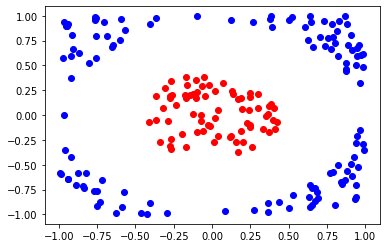

测试集 100 个数据点的可视化：


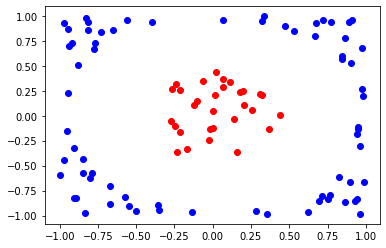


 读者不妨自己调节数据集的参数设置来生成属于自己的数据集吧！


In [4]:
# 数据集参数设置
Ntrain=200        # 规定训练集大小
Ntest=100         # 规定测试集大小
boundary_gap=0.5  # 设置决策边界的宽度
seed_data=2       # 固定随机种子

# 生成自己的数据集
train_x, train_y, test_x, test_y = circle_data_point_generator(
        Ntrain, Ntest, boundary_gap, seed_data)
print("训练集 {} 个数据点的可视化：".format(Ntrain))
data_point_plot(train_x, train_y)
print("测试集 {} 个数据点的可视化：".format(Ntest))
data_point_plot(test_x, test_y)
print("\n 读者不妨自己调节数据集的参数设置来生成属于自己的数据集吧！")

## 数据的预处理

与经典机器学习不同的是，量子分类器在实际工作的时候需要考虑数据的预处理。我们需要多加一个步骤将经典的数据转化成量子信息才能放在量子计算机上跑。接下来我们看看具体是怎么完成的。首先我们确定需要使用的量子比特数量。因为我们的数据 $\{x^{(i)} = (x^{(i)}_0, x^{(i)}_1)\}$ 是二维的, 按照 Mitarai (2018) 论文中的编码方式我们至少需要2个量子比特。接着准备一系列的初始量子态 $\lvert {00}\rangle$。然后将经典信息 $\{x^{(i)}\}$ 编码成一系列量子门 $U(x^{(i)})$ 并作用在初始量子态上。最终得到一系列的量子态 $\lvert {\psi^{(i)}}\rangle = U(x^{(i)})\lvert {00}\rangle$。这样我们就完成从经典信息到量子信息的编码了！给定 $m$ 个量子比特去编码二维的经典数据点，则量子门的构造为：

$$
U(x^{(i)}) = \otimes_{j=0}^{m-1} R_j^z\big[\arccos(x^{(i)}_{j \, \text{mod} \, 2}\cdot x^{(i)}_{j \, \text{mod} \, 2})\big] R_j^y\big[\arcsin(x^{(i)}_{j \, \text{mod} \, 2}) \big]
$$

注意：这种表示下，我们将第一个量子比特编号为 $j = 0$。下标 $j$ 表示旋转门 $R_z$ 或者 $R_y$ 作用在第 $j+1$ 个量子比特上。论文中作者并没有提及为何要这么编码经典信息，更多编码方式见 [Robust data encodings for quantum classifiers](https://arxiv.org/pdf/2003.01695.pdf)。这里我们也欢迎读者自己创新尝试全新的编码方式！由于这种编码的方式看着比较复杂，我们不妨来举一个简单的例子。假设我们给定一个数据点 $x = (x_0, x_1)= (1,0)$, 显然这个数据点的标签应该为 1，对应上图**蓝色**的点。同时数据点对应的2比特量子门 $U(x)$ 是

$$
U(x) = 
\bigg( R_0^z\big[\arccos(x_{0}\cdot x_{0})\big] R_0^y\big[\arcsin(x_{0}) \big]  \bigg)
\otimes 
\bigg( R_1^z\big[\arccos(x_{1}\cdot x_{1})\big] R_1^y\big[\arcsin(x_{1}) \big] \bigg)
$$

把具体的数值带入我们就能得到：
$$
U(x) = 
\bigg( R_0^z\big[0\big] R_0^y\big[\pi/2 \big]  \bigg)
\otimes 
\bigg( R_1^z\big[\pi/2\big] R_1^y\big[0 \big] \bigg)
$$

我们回忆一下常用的旋转门的矩阵形式：


$$ 
R_x(\theta) := 
\begin{bmatrix} 
\cos \frac{\theta}{2} &-i\sin \frac{\theta}{2} \\ 
-i\sin \frac{\theta}{2} &\cos \frac{\theta}{2} 
\end{bmatrix}
,\quad 
R_y(\theta) := 
\begin{bmatrix}
\cos \frac{\theta}{2} &-\sin \frac{\theta}{2} \\ 
\sin \frac{\theta}{2} &\cos \frac{\theta}{2} 
\end{bmatrix}
,\quad 
R_z(\theta) := 
\begin{bmatrix}
e^{-i\frac{\theta}{2}} & 0 \\ 
0 & e^{i\frac{\theta}{2}}
\end{bmatrix}
$$

那么这个两比特量子门 $U(x)$ 的矩阵形式可以写为：

$$
U(x) = 
\bigg(
\begin{bmatrix}
1 & 0 \\ 
0 & 1
\end{bmatrix}
\begin{bmatrix}
\cos \frac{\pi}{4} &-\sin \frac{\pi}{4} \\ 
\sin \frac{\pi}{4} &\cos \frac{\pi}{4} 
\end{bmatrix}
\bigg)
\otimes 
\bigg(
\begin{bmatrix}
e^{-i\frac{\pi}{4}} & 0 \\ 
0 & e^{i\frac{\pi}{4}}
\end{bmatrix}
\begin{bmatrix}
1 &0 \\ 
0 &1
\end{bmatrix}
\bigg)
$$

化简后我们作用在零初始化的 $\lvert {00}\rangle$ 量子态上可以得到编码后的量子态 $\lvert {\psi}\rangle$，

$$
\lvert {\psi}\rangle =
U(x)\lvert {00}\rangle = \frac{1}{2}
\begin{bmatrix}
1-i &0 &-1+i &0 \\ 
0 &1+i &0  &-1-i \\
1-i &0 &1-i  &0 \\
0 &1+i &0  &1+i 
\end{bmatrix}
\begin{bmatrix}
1 \\
0 \\
0 \\
0
\end{bmatrix}
= \frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}
$$

接着我们来看看代码上怎么实现这种编码方式。需要注意的是：代码中使用了一个张量积的小技巧

$$
(U_1 \lvert {0}\rangle)\otimes (U_2 \lvert {0}\rangle) = (U_1 \otimes U_2) \lvert {0}\rangle\otimes\lvert {0}\rangle
= (U_1 \otimes U_2) \lvert {00}\rangle
$$

In [5]:
def myRy(theta):
    """
    :param theta: parameter
    :return: Y rotation matrix
    """
    return np.array([[np.cos(theta / 2), -np.sin(theta / 2)],
                     [np.sin(theta / 2), np.cos(theta / 2)]])

def myRz(theta):
    """
    :param theta: parameter
    :return: Z rotation matrix
    """
    return np.array([[np.cos(theta / 2) - np.sin(theta / 2) * 1j, 0],
                     [0, np.cos(theta / 2) + np.sin(theta / 2) * 1j]])

# 经典 -> 量子数据编码器
def datapoints_transform_to_state(data, n_qubits):
    """
    :param data: shape [-1, 2]
    :param n_qubits: the number of qubits to which the data transformed
    :return: shape [-1, 1, 2 ^ n_qubits]
    """
    dim1, dim2 = data.shape
    res = []
    for sam in range(dim1):
        res_state = 1.
        zero_state = np.array([[1, 0]])
        for i in range(n_qubits):
            if i % 2 == 0:
                state_tmp=np.dot(zero_state, myRy(np.arcsin(data[sam][0])).T)
                state_tmp=np.dot(state_tmp, myRz(np.arccos(data[sam][0] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
            elif i % 2 == 1:
                state_tmp=np.dot(zero_state, myRy(np.arcsin(data[sam][1])).T)
                state_tmp=np.dot(state_tmp, myRz(np.arccos(data[sam][1] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
        res.append(res_state)

    res = np.array(res)
    return res.astype("complex128")

print("作为测试我们输入以上的经典信息:")
print("(x_0, x_1) = (1, 0)")
print("编码后输出的2比特量子态为:")
print(datapoints_transform_to_state(np.array([[1, 0]]), n_qubits=2))

作为测试我们输入以上的经典信息:
(x_0, x_1) = (1, 0)
编码后输出的2比特量子态为:
[[[0.5-0.5j 0. +0.j  0.5-0.5j 0. +0.j ]]]


## 构造量子神经网络 （QNN）

那么在完成上述从经典数据到量子数据的编码后，我们现在可以把这些量子态输入到量子计算机里面了。在那之前，我们还需要设计下我们所采用的网络结构。

<img src="figures/classifier_circuit.png" width="600" >

为了方便，我们统一将上述参数化的量子神经网络称为 $U(\boldsymbol{\theta})$。这个 $U(\boldsymbol{\theta})$ 是我们分类器的关键组成部分，他需要一定的复杂结构来拟合我们的决策边界。这一点和传统的神经网络是类似的。我们还是拿原来提过的这个数据点 $x = (x_0, x_1)= (1,0)$ 来举例子，编码过后我们已经得到了一个量子态 $\lvert {\psi}\rangle$，

$$
\lvert {\psi}\rangle =
\frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}
$$

接着我们把这个量子态输入进我们的量子神经网络（QNN），也就是把一个酉矩阵乘以一个向量。得到处理过后的量子态 $\lvert {\varphi}\rangle$

$$
\lvert {\varphi}\rangle = U(\boldsymbol{\theta})\lvert {\psi}\rangle
$$

如果我们把所有的参数 $\theta$ 都设置为 $\theta = \pi$, 那么我们就可以写出具体的矩阵了：

$$
\lvert {\varphi}\rangle = 
U(\boldsymbol{\theta} =\pi)\lvert {\psi}\rangle=
\begin{bmatrix}
0  &0 &-1 &0 \\ 
-1 &0 &0  &0 \\
0  &1 &0  &0 \\
0  &0 &0  &1 
\end{bmatrix}
\cdot
\frac{1}{2}
\begin{bmatrix}
1-i \\
0 \\
1-i \\
0
\end{bmatrix}
= \frac{1}{2}
\begin{bmatrix}
-1+i \\
-1+i \\
0 \\
0
\end{bmatrix}
$$

In [6]:
# 模拟搭建量子神经网络
def U_theta(theta, n, depth):  
    """
    :param theta: dim: [n, depth + 3]
    :param n: number of qubits
    :param depth: circuit depth
    :return: U_theta
    """
    # 初始化网络
    cir = UAnsatz(n)
    
    # 先搭建广义的旋转层
    for i in range(n):
        cir.rz(theta[i][0], i)
        cir.ry(theta[i][1], i)
        cir.rz(theta[i][2], i)

    # 默认深度为 depth = 1
    # 搭建纠缠层和 Ry旋转层
    for d in range(3, depth + 3):
        for i in range(n-1):
            cir.cnot([i, i + 1])
        cir.cnot([n-1, 0])
        for i in range(n):
            cir.ry(theta[i][d], i)

    return cir.U

# 测量与损失函数

当我们在量子计算机上（QPU）用 QNN 处理过初始量子态 $\lvert {\psi}\rangle$ 后， 我们需要重新测量这个新的量子态 $\lvert {\varphi}\rangle$ 来获取经典信息。这些处理过后的经典信息可以用来计算损失函数 $\mathcal{L}(\boldsymbol{\theta})$。最后我们再通过经典计算机（CPU）来不断更新QNN参数 $\boldsymbol{\theta}$ 并优化损失函数。这里我们采用的测量方式是测量泡利 $Z$ 算符在第一个量子比特上的期望值。 具体来说，

$$
\langle Z \rangle = 
\langle \varphi |Z\otimes I\cdots \otimes I| \varphi\rangle
$$

复习一下，泡利 $Z$ 算符的矩阵形式为：

$$ Z := \begin{bmatrix} 1 &0 \\ 0 &-1 \end{bmatrix}$$

继续我们前面的2量子比特的例子，测量过后我们得到的期望值就是：

$$
\langle Z \rangle = 
\langle \varphi |Z\otimes I| \varphi\rangle = 
\frac{1}{2}
\begin{bmatrix}
-1-i \quad
-1-i \quad
0   \quad
0
\end{bmatrix}
\begin{bmatrix}
1  &0 &0  &0 \\ 
0  &1 &0  &0 \\
0  &0 &-1 &0 \\
0  &0 &0  &-1 
\end{bmatrix}
\cdot
\frac{1}{2}
\begin{bmatrix}
-1+i \\
-1+i \\
0 \\
0
\end{bmatrix}
= 1
$$

好奇的读者就会问了，咦？这个测量结果好像就是我们原来的标签1啊，这是不是意味着我们已经成功的分类这个数据点了？其实并不然，因为 $\langle Z \rangle$ 的取值范围通常在 $[-1,1]$之间。 为了对应我们的标签范围 $y^{(i)} \in \{0,1\}$, 我们还需要将区间上下限映射上。这个映射最简单的做法就是让

$$
\tilde{y}^{(i)} = \frac{\langle Z \rangle}{2} + \frac{1}{2} + bias \quad \in [0, 1]
$$

其中加入偏置（bias）是机器学习中的一个小技巧，目的就是为了让决策边界不受制于原点或者一些超平面。一般我们默认偏置初始化为0，并且优化器在迭代过程中会类似于参数 $\theta$ 一样不断更新偏置确保 $\tilde{y}^{(i)} \in [0, 1]$。当然读者也可以选择其他复杂的映射比如说 sigmoid 函数。映射过后我们就可以把 $\tilde{y}^{(i)}$ 看作是我们估计出的标签（label）了。如果 $\tilde{y}^{(i)}< 0.5$ 就对应标签 0，如果 $\tilde{y}^{(i)}> 0.5$  就对应标签 1。 我们稍微复习一下整个流程，


$$
x^{(i)} \rightarrow \lvert {\psi}\rangle^{(i)} \rightarrow U(\boldsymbol{\theta})\lvert {\psi}\rangle^{(i)} \rightarrow
\lvert {\varphi}\rangle^{(i)} \rightarrow ^{(i)}\langle \varphi |Z\otimes I\cdots \otimes I| \varphi\rangle^{(i)}
\rightarrow \langle Z \rangle  \rightarrow \tilde{y}^{(i)}
$$

最后我们就可以把损失函数定义为平方损失函数：

$$
\mathcal{L} = \sum_{(i)} |y^{(i)} - \tilde{y}^{(i)}|^2
$$

In [7]:
# 生成只作用在第一个量子比特上的泡利 Z 算符
# 其余量子比特上都作用单位矩阵
def Observable(n):
    """
    :param n: number of qubits
    :return: local observable: Z \otimes I \otimes ...\otimes I
    """
    Ob = pauli_str_to_matrix([[1.0, 'z0']], n)
    return Ob

In [8]:
# 搭建整个优化流程图
class Net(fluid.dygraph.Layer):
    """
    Construct the model net
    """
    def __init__(self,
                 n,      # number of qubits
                 depth,  # circuit depth
                 seed_paras=1,
                 dtype='float64'):
        super(Net, self).__init__()

        self.n = n
        self.depth = depth
        
        # 初始化参数列表 theta，并用 [0, 2*pi] 的均匀分布来填充初始值
        self.theta = self.create_parameter(
            shape=[n, depth + 3],
            attr=fluid.initializer.Uniform(
                low=0.0, high=2*PI, seed=seed_paras),
            dtype=dtype,
            is_bias=False)
        
        # 初始化偏置 (bias)
        self.bias = self.create_parameter(
            shape=[1],
            attr=fluid.initializer.NormalInitializer(
                scale=0.01, seed=seed_paras + 10),
            dtype=dtype,
            is_bias=False)

    # 定义向前传播机制、计算损失函数 和交叉验证正确率
    def forward(self, state_in, label):
        """
        Args:
            state_in: The input quantum state, shape [-1, 1, 2^n]
            label: label for the input state, shape [-1, 1]
        Returns:
            The loss:
                L = ((<Z> + 1)/2 + bias - label)^2
        """
        
        # 我们需要将 Numpy array 转换成 Paddle 动态图模式中支持的 variable
        Ob = fluid.dygraph.to_variable(Observable(self.n))
        label_pp = fluid.dygraph.to_variable(label)

        # 按照随机初始化的参数 theta 
        Utheta = U_theta(self.theta, n=self.n, depth=self.depth)
        
        # 因为 Utheta是学习得到的，我们这里用行向量运算来提速而不会影响训练效果
        state_out = matmul(state_in, Utheta)  # 维度 [-1, 1, 2 ** n]
        
        # 测量得到泡利 Z 算符的期望值 <Z>
        E_Z = matmul(matmul(state_out, Ob),
                     transpose(ComplexVariable(state_out.real, -state_out.imag),
                               perm=[0, 2, 1]))
        
        # 映射 <Z> 处理成标签的估计值 
        state_predict = E_Z.real[:, 0] * 0.5 + 0.5 + self.bias
        loss = fluid.layers.reduce_mean((state_predict - label_pp) ** 2)
        
        # 计算交叉验证正确率
        is_correct = fluid.layers.where(
            fluid.layers.abs(state_predict - label_pp) < 0.5).shape[0]
        acc = is_correct / label.shape[0]

        return loss, acc, state_predict.numpy()

## 训练效果与调参

好了， 那么定义完以上所有的概念之后我们不妨来看看实际的训练效果！

In [9]:
def heatmap_plot(net, N):
    # generate data points x_y_
    Num_points = 30
    x_y_ = []
    for row_y in np.linspace(0.9, -0.9, Num_points):
        row = []
        for row_x in np.linspace(-0.9, 0.9, Num_points):
            row.append([row_x, row_y])
        x_y_.append(row)
    x_y_ = np.array(x_y_).reshape(-1, 2).astype("float64")

    # compute the prediction: heat_data
    input_state_test = fluid.dygraph.to_variable(
        datapoints_transform_to_state(x_y_, N))
    loss_useless, acc_useless, state_predict = net(state_in=input_state_test,
                                                   label=x_y_[:, 0])
    heat_data = state_predict.reshape(Num_points, Num_points)

    # plot
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    x_label = np.linspace(-0.9, 0.9, 3)
    y_label = np.linspace(0.9, -0.9, 3)
    ax.set_xticks([0, Num_points // 2, Num_points - 1])
    ax.set_xticklabels(x_label)
    ax.set_yticks([0, Num_points // 2, Num_points - 1])
    ax.set_yticklabels(y_label)
    im = ax.imshow(heat_data, cmap=plt.cm.RdBu)
    plt.colorbar(im)
    plt.show()

def QClassifier(Ntrain, Ntest, gap, N, D, EPOCH, LR, BATCH, seed_paras, seed_data,):
    """
    Quantum Binary Classifier
    """
    # 初始化paddle动态图机制
    with fluid.dygraph.guard():
        
        # 生成数据集
        train_x, train_y, test_x, test_y = circle_data_point_generator(
            Ntrain=Ntrain, Ntest=Ntest, boundary_gap=gap, seed_data=seed_data)
        
        # 读取训练集的维度
        N_train = train_x.shape[0]
        
        # 定义优化图
        net = Net(n=N, depth=D, seed_paras=seed_paras)
        
        # 一般来说，我们利用Adam优化器来获得相对好的收敛，当然你可以改成SGD或者是RMSprop
        opt = fluid.optimizer.AdamOptimizer(
            learning_rate=LR, parameter_list=net.parameters())
        
        # 初始化寄存器存储正确率 acc 等信息
        summary_iter, summary_test_acc = [], []
        
        # 优化循环
        for ep in range(EPOCH):
            for itr in range(N_train // BATCH):
                
                # 将经典数据编码成量子态 |psi>, 维度 [-1, 2 ** N]
                input_state = fluid.dygraph.to_variable(
                    datapoints_transform_to_state(
                    train_x[itr * BATCH:(itr + 1) * BATCH], N))
                
                # 前向传播计算损失函数
                loss, train_acc, state_predict_useless \
                    = net(state_in=input_state,
                          label=train_y[itr * BATCH:(itr + 1) * BATCH])
                if itr % 10 == 0:
                    # 计算测试集上的正确率 test_acc
                    input_state_test = fluid.dygraph.to_variable(
                        datapoints_transform_to_state(test_x, N))
                    loss_useless, test_acc, state_predict_useless \
                        = net(state_in=input_state_test,
                              label=test_y)
                    print("epoch:", ep, "iter:", itr,
                          "loss: %.4f" % loss.numpy(),
                          "train acc: %.4f" % train_acc,
                          "test acc: %.4f" % test_acc)
                    
                    # 存储正确率 acc 等信息
                    summary_iter.append(itr + ep * N_train)
                    summary_test_acc.append(test_acc)
                    
                # 在动态图机制下，反向传播极小化损失函数
                loss.backward()
                opt.minimize(loss)
                net.clear_gradients()

        # 画出 heatmap 表示的决策边界
        heatmap_plot(net, N=N)

    return summary_test_acc

训练集的维度大小 x (200, 2) 和 y (200, 1)
测试集的维度大小 x (100, 2) 和 y (100, 1) 

epoch: 0 iter: 0 loss: 0.0249 train acc: 1.0000 test acc: 0.5200
epoch: 0 iter: 10 loss: 0.5726 train acc: 0.0000 test acc: 0.5700
epoch: 0 iter: 20 loss: 0.0702 train acc: 1.0000 test acc: 0.6500
epoch: 0 iter: 30 loss: 0.0947 train acc: 1.0000 test acc: 0.6900
epoch: 0 iter: 40 loss: 0.2799 train acc: 0.0000 test acc: 0.7100
epoch: 0 iter: 50 loss: 0.1501 train acc: 1.0000 test acc: 0.7500
epoch: 0 iter: 60 loss: 0.1587 train acc: 1.0000 test acc: 0.8400
epoch: 0 iter: 70 loss: 0.1633 train acc: 1.0000 test acc: 0.9500
epoch: 0 iter: 80 loss: 0.2033 train acc: 1.0000 test acc: 1.0000
epoch: 0 iter: 90 loss: 0.1852 train acc: 1.0000 test acc: 1.0000
epoch: 0 iter: 100 loss: 0.1369 train acc: 1.0000 test acc: 1.0000
epoch: 0 iter: 110 loss: 0.1306 train acc: 1.0000 test acc: 1.0000
epoch: 0 iter: 120 loss: 0.1341 train acc: 1.0000 test acc: 1.0000
epoch: 0 iter: 130 loss: 0.1072 train acc: 1.0000 test acc: 1.0000
epoch

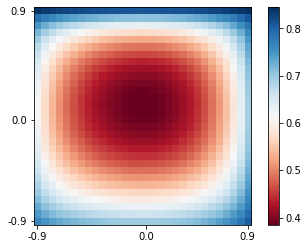

主程序段总共运行了 52.354016065597534 秒


In [10]:
def main():
    """
    main
    """
    time_start = time.time()
    acc = QClassifier(
        Ntrain = 200,        # 规定训练集大小
        Ntest = 100,         # 规定测试集大小
        gap = 0.5,           # 设定决策边界的宽度
        N = 4,               # 所需的量子比特数量
        D = 1,               # 采用的电路深度
        EPOCH = 4,           # 训练 epoch 轮数
        LR = 0.01,           # 设置学习速率
        BATCH = 1,           # 训练时 batch 的大小
        seed_paras = 19,     # 设置随机种子用以初始化各种参数
        seed_data = 2,       # 固定生成数据集所需要的随机种子
    )
    
    time_span = time.time() - time_start
    print('主程序段总共运行了', time_span, '秒')

if __name__ == '__main__':
    main()

<hr/>

# 参考文献

[1] [Mitarai, K., Negoro, M., Kitagawa, M. & Fujii, K. Quantum circuit learning. Phys. Rev. A 98, 032309 (2018).](https://arxiv.org/abs/1803.00745)

[2] [Schuld, M., Bocharov, A., Svore, K. M. & Wiebe, N. Circuit-centric quantum classifiers. Phys. Rev. A 101, 032308 (2020).](https://arxiv.org/abs/1804.00633)